In [ ]:
"""
This example is the same as the previous nn_quadratic_d1, except here we use nn.Sequential 
and similar network setup as FitSNAP.
"""

In [15]:
%matplotlib inline

import numpy as np

from matplotlib import pyplot as plt

import torch
from torch import nn
from torch import tensor

torch.Size([30, 1])
torch.Size([30])


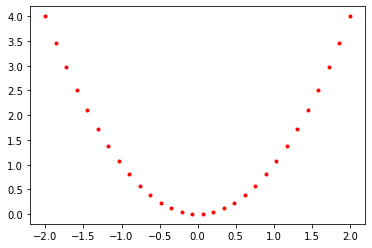

In [34]:
X = torch.linspace(-2., 2., 30).unsqueeze(1)
print(X.shape)
#Y = torch.cat([torch.zeros(10),  torch.linspace(0., 1., 10), 1. + torch.zeros(10)], dim=0)
Y = torch.square(X).flatten()
targets = Y
print(Y.shape)
plt.plot(X.squeeze().numpy(), Y.numpy(), 'r.')

In [3]:
print(X)

tensor([[-2.0000],
        [-1.8621],
        [-1.7241],
        [-1.5862],
        [-1.4483],
        [-1.3103],
        [-1.1724],
        [-1.0345],
        [-0.8966],
        [-0.7586],
        [-0.6207],
        [-0.4828],
        [-0.3448],
        [-0.2069],
        [-0.0690],
        [ 0.0690],
        [ 0.2069],
        [ 0.3448],
        [ 0.4828],
        [ 0.6207],
        [ 0.7586],
        [ 0.8966],
        [ 1.0345],
        [ 1.1724],
        [ 1.3103],
        [ 1.4483],
        [ 1.5862],
        [ 1.7241],
        [ 1.8621],
        [ 2.0000]])


In [5]:
"""
Define the network parameters
"""
#layer_sizes = ['num_desc', '10', '8', '6', '1'] # FitSNAP style
layer_sizes = [1, 10, 1]

In [6]:
def create_torch_network(layer_sizes):
    """
    Creates a pytorch network architecture from layer sizes.
    This also performs standarization in the first linear layer.
    ADR: No I don't think it standardizes anything...
    This only supports softplus as the nonlinear activation function.

        Parameters:
            layer_sizes (list of ints): Size of each network layers

        Return:
            Network Architecture of type neural network sequential

    """
    layers = []
    try:
        layers.append(torch.nn.Linear(layer_sizes[0], layer_sizes[0]))
        for i, layer in enumerate(layer_sizes):
            layers.append(torch.nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            layers.append(torch.nn.Softplus())
    except IndexError:
        layers.pop()
    return torch.nn.Sequential(*layers)

network_architecture = create_torch_network(layer_sizes)
print(network_architecture)
for name, param in network_architecture.named_parameters():
    print(name)
    print(param)

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
  (1): Linear(in_features=1, out_features=10, bias=True)
  (2): Softplus(beta=1, threshold=20)
  (3): Linear(in_features=10, out_features=1, bias=True)
)
0.weight
Parameter containing:
tensor([[-0.2667]], requires_grad=True)
0.bias
Parameter containing:
tensor([0.4186], requires_grad=True)
1.weight
Parameter containing:
tensor([[-0.1618],
        [ 0.0781],
        [ 0.5282],
        [-0.4218],
        [-0.0592],
        [ 0.6926],
        [-0.6247],
        [ 0.1218],
        [-0.3514],
        [-0.1638]], requires_grad=True)
1.bias
Parameter containing:
tensor([-0.5741,  0.0307,  0.1016,  0.9004, -0.4631,  0.7461, -0.6290, -0.4857,
         0.6721, -0.9628], requires_grad=True)
3.weight
Parameter containing:
tensor([[ 0.0172,  0.0664, -0.1803,  0.2008,  0.1156, -0.0802,  0.2120,  0.0131,
          0.0942,  0.2196]], requires_grad=True)
3.bias
Parameter containing:
tensor([0.2862], requires_grad=True)


In [19]:
"""
Define the model
"""
class FitTorch(torch.nn.Module):
    """
    FitSNAP PyTorch Neural Network Architecture Model
    Currently only fits on energies
    """

    def __init__(self, network_architecture, descriptor_count, n_elements=1):
        """
        Saves lammps ready pytorch model.

            Parameters:
                network_architecture : A nn.Sequential network architecture
                descriptor_count (int): Length of descriptors for an atom
                n_elements (int): Number of differentiable atoms types

        """
        super().__init__()
        self.network_architecture = network_architecture
        self.desc_len = descriptor_count
        self.n_elem = n_elements
        
    def forward(self, x, indices, atoms_per_structure):
        """
        Saves lammps ready pytorch model.

            Parameters:
                x (tensor of floats): Array of descriptors
                indices (tensor of ints): Array of indices upon which to contract per atom energies
                atoms_per_structure (tensor of ints): Number of atoms per configuration

        """

        predicted_energy_total = torch.zeros(atoms_per_structure.size())
        #print(self.network_architecture(x))
        predicted_energy_total.index_add_(0, indices, self.network_architecture(x).squeeze())
        return predicted_energy_total

    def import_wb(self, weights, bias):
        """
        Imports weights and bias into FitTorch model

            Parameters:
                weights (list of numpy array of floats): Network weights at each layer
                bias (list of numpy array of floats): Network bias at each layer

        """

        assert len(weights) == len(bias)
        imported_parameter_count = sum(w.size + b.size for w, b in zip(weights, bias))
        combined = [None] * (len(weights) + len(bias))
        combined[::2] = weights
        combined[1::2] = bias

        assert len([p for p in self.network_architecture.parameters()]) == len(combined)
        assert sum(p.nelement() for p in self.network_architecture.parameters()) == imported_parameter_count

        state_dict = self.state_dict()
        for i, key in enumerate(state_dict.keys()):
            state_dict[key] = torch.tensor(combined[i])
        self.load_state_dict(state_dict)

In [20]:
"""
Create the model.
"""
nd = 1
model = FitTorch(network_architecture, 1)
print(model)
#print(model.network_architecture,0,weight)

FitTorch(
  (network_architecture): Sequential(
    (0): Linear(in_features=1, out_features=1, bias=True)
    (1): Linear(in_features=1, out_features=10, bias=True)
    (2): Softplus(beta=1, threshold=20)
    (3): Linear(in_features=10, out_features=1, bias=True)
  )
)


In [32]:
nconfigs = 30
num_atoms = torch.ones(nconfigs,dtype=torch.int32) # number of atoms per config
descriptors = X
indices = np.linspace(0,nconfigs-1,30).astype(int)
indices = torch.from_numpy(indices)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
print(model.parameters)
print(indices)
#print(descriptors)
#print(indices)
#print(type(num_atoms))
test = model(descriptors, indices, num_atoms)
print(test)
energies = torch.reshape(model(descriptors, indices, num_atoms), (-1,)).to(device)
print(energies)

<bound method Module.parameters of FitTorch(
  (network_architecture): Sequential(
    (0): Linear(in_features=1, out_features=1, bias=True)
    (1): Linear(in_features=1, out_features=10, bias=True)
    (2): Softplus(beta=1, threshold=20)
    (3): Linear(in_features=10, out_features=1, bias=True)
  )
)>
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])
tensor([0.4802, 0.4882, 0.4962, 0.5042, 0.5123, 0.5203, 0.5284, 0.5364, 0.5445,
        0.5526, 0.5607, 0.5689, 0.5770, 0.5852, 0.5933, 0.6015, 0.6097, 0.6179,
        0.6261, 0.6343, 0.6426, 0.6508, 0.6591, 0.6674, 0.6757, 0.6840, 0.6923,
        0.7006, 0.7090, 0.7173], grad_fn=<IndexAddBackward1>)
tensor([0.4802, 0.4882, 0.4962, 0.5042, 0.5123, 0.5203, 0.5284, 0.5364, 0.5445,
        0.5526, 0.5607, 0.5689, 0.5770, 0.5852, 0.5933, 0.6015, 0.6097, 0.6179,
        0.6261, 0.6343, 0.6426, 0.6508, 0.6591, 0.6674, 0.6757, 0.6840, 0.6923,
        0.7006,

In [38]:
"""
Train
"""
for epoch in range(100):
    print(epoch)
    energies = torch.reshape(model(descriptors, indices, num_atoms), (-1,)).to(device)
    loss = loss_function(energies/num_atoms, targets)
    print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0
epoch: 1, loss = 0.0086
1
epoch: 2, loss = 0.0082
2
epoch: 3, loss = 0.0078
3
epoch: 4, loss = 0.0076
4
epoch: 5, loss = 0.0072
5
epoch: 6, loss = 0.0069
6
epoch: 7, loss = 0.0066
7
epoch: 8, loss = 0.0063
8
epoch: 9, loss = 0.0060
9
epoch: 10, loss = 0.0057
10
epoch: 11, loss = 0.0054
11
epoch: 12, loss = 0.0052
12
epoch: 13, loss = 0.0049
13
epoch: 14, loss = 0.0047
14
epoch: 15, loss = 0.0045
15
epoch: 16, loss = 0.0043
16
epoch: 17, loss = 0.0041
17
epoch: 18, loss = 0.0040
18
epoch: 19, loss = 0.0038
19
epoch: 20, loss = 0.0037
20
epoch: 21, loss = 0.0035
21
epoch: 22, loss = 0.0034
22
epoch: 23, loss = 0.0033
23
epoch: 24, loss = 0.0032
24
epoch: 25, loss = 0.0031
25
epoch: 26, loss = 0.0029
26
epoch: 27, loss = 0.0028
27
epoch: 28, loss = 0.0027
28
epoch: 29, loss = 0.0027
29
epoch: 30, loss = 0.0026
30
epoch: 31, loss = 0.0025
31
epoch: 32, loss = 0.0024
32
epoch: 33, loss = 0.0023
33
epoch: 34, loss = 0.0023
34
epoch: 35, loss = 0.0022
35
epoch: 36, loss = 0.0022
36
epoch: 3

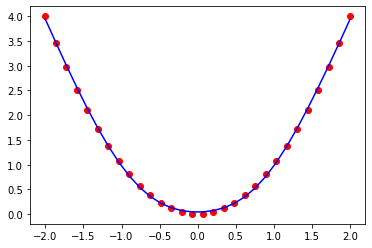

In [39]:
# Plot
predicted = model(descriptors,indices,num_atoms).detach().numpy()

plt.plot(X.numpy(), Y.numpy(), 'ro')
plt.plot(X.numpy(), predicted, 'b')
plt.show()